# Import Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [6]:
from dataset import ParkingSpotDataset

train_dataset = ParkingSpotDataset(image_size=448, data_dir="data/Parking Space.v4i.darknet/train", transform=None)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)



/Users/andrewpark/Parking-Spot-Detection/dataset.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bboxes = torch.tensor(bboxes, dtype=torch.float32)
/Users/andrewpark/Parking-Spot-Detection/dataset.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


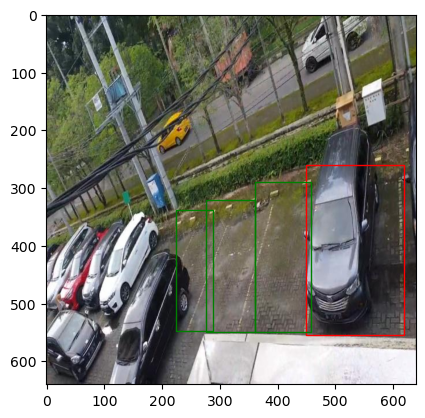

In [7]:
from utils import visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches



for i, (image, boxes, labels) in enumerate(train_loader):
    image = image[0]
    boxes = boxes[0].numpy()
    labels = labels[0].tolist()
    plt.show()
    visualization.plot_image(image, boxes, labels)
    break

In [8]:
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
from utils.detection import *
from utils.visualization import *
# from loss import *
from dataset import *
from model.yolov1 import *
from torch.utils import model_zoo

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

lr = 0.001
batch_size = 64
weight_decay = 0.0005
epochs = 20
data_dir = "data/train"

def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

model = YOLOv1(S=7, B=2, C=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss = YoloLoss(S=7, B=2, C=2)

# train_dataset = ParkingSpotDataset(
#     image_size=448,
#     data_dir=data_dir,
#     S=7,
#     B=2,
#     C=2
# )

# train_loader = DataLoader(
#     dataset=train_dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     drop_last=True,
# )

for epoch in range(epochs):
    pred_boxes, target_boxes = get_bboxes(
        train_loader, model, iou_threshold=0.5, threshold=0.4
    )

    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
    )
    print(f"Train mAP: {mean_avg_prec}")
    train_fn(train_loader, model, optimizer, loss)


TypeError: YOLOv1.__init__() got an unexpected keyword argument 'S'